# Find the central star of CTIO Data in May 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   :May 29th 2017


The goal of this notebook is to cut a part of the image around the main central star.
The rest of the image is useless.
This region around the central star is necessary to perform the rotation of the images without
any biases due to other stars.


In [82]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [83]:
print theNotebook

FindCentralStar


In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [85]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [86]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [87]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.2.0


In [88]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [89]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [90]:
from IPython.display import Image, display

In [91]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [92]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [93]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)¶

In [94]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [95]:
ensure_dir(dir_top_images) # create that directory

### Input directory

In [96]:
inputdir="../OverScanRemove/trim_images"
MIN_IMGNUMBER=16
MAX_IMGNUMBER=25
object_name='HD11190'
SelectTagRe='^trim_20170528_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^trim_20170528_[0-9]+.fits$'

In [97]:

NBIMGPERLROW=4

### Output directory fot fits images

In [98]:
outputdir="./cut_fitsimages"

In [99]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [100]:
input_filelist=os.listdir(inputdir) 

In [101]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [102]:
print input_filelist[:5]

['trim_20170528_001.fits' 'trim_20170528_002.fits' 'trim_20170528_004.fits'
 'trim_20170528_005.fits' 'trim_20170528_006.fits']


In [103]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list
dirlist_all = [inputdir]

In [104]:
def MakeFileList():
    """
    MakeFileList : Make The List of files to open
    =============
    
    - we select the files which are of interest.
    - In particular select the number range
    
    """
    count=0
    
    for dir in dirlist_all: # loop on directories, one per image   (if necessary)    
            dir_leaf= dir # build the name of leaf directory
            listfiles=os.listdir(dir_leaf) 
            for filename in listfiles:
                if re.search(SearchTagRe,filename):  #example of filename filter
                    str_index=re.findall(SelectTagRe,filename)
                    count=count+1
                    index=int(str_index[0])
                    if index >= MIN_IMGNUMBER and index <= MAX_IMGNUMBER: 
                        indexes_files.append(index)         
                        shortfilename=dir_leaf+'/'+filename
                        filelist_fitsimages.append(shortfilename)
                    
    return 

In [105]:
MakeFileList()   # Make the list

In [106]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [107]:
print indexes_files

[16 17 18 19 20 21 22 23 24 25]


In [108]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [109]:
sorted_numbers=indexes_files[sorted_indexes]

In [110]:
print sorted_indexes

[0 1 2 3 4 5 6 7 8 9]


In [111]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [112]:
sorted_files

array(['../OverScanRemove/trim_images/trim_20170528_016.fits',
       '../OverScanRemove/trim_images/trim_20170528_017.fits',
       '../OverScanRemove/trim_images/trim_20170528_018.fits',
       '../OverScanRemove/trim_images/trim_20170528_019.fits',
       '../OverScanRemove/trim_images/trim_20170528_020.fits',
       '../OverScanRemove/trim_images/trim_20170528_021.fits',
       '../OverScanRemove/trim_images/trim_20170528_022.fits',
       '../OverScanRemove/trim_images/trim_20170528_023.fits',
       '../OverScanRemove/trim_images/trim_20170528_024.fits',
       '../OverScanRemove/trim_images/trim_20170528_025.fits'], 
      dtype='|S52')

## Build full filename
----------------------------

In [113]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [114]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [115]:
print sorted_filenames.shape

(10,)


## Acces to data of  images
----------------------------------

In [116]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []

In [117]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
    
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header

In [118]:
all_dates,all_airmass,all_images,all_titles,all_header=BuildImages(sorted_files,sorted_numbers,object_name)

## Show images
-----------------------

In [119]:
len(all_images)

10

In [120]:
def ShowRawImages():
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    #global all_images
    #global all_titles
    #global object_name

    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERLROW)+1

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=(20,20))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        #im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',norm=LogNorm(vmin=0.1, vmax=10))
        im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',vmin=0, vmax=1000)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
    title='Raw images of {}'.format(object_name)
    plt.suptitle(title,size=16)    
    figfilename=os.path.join(dir_top_images,'input_images.pdf')
    plt.savefig(figfilename)   

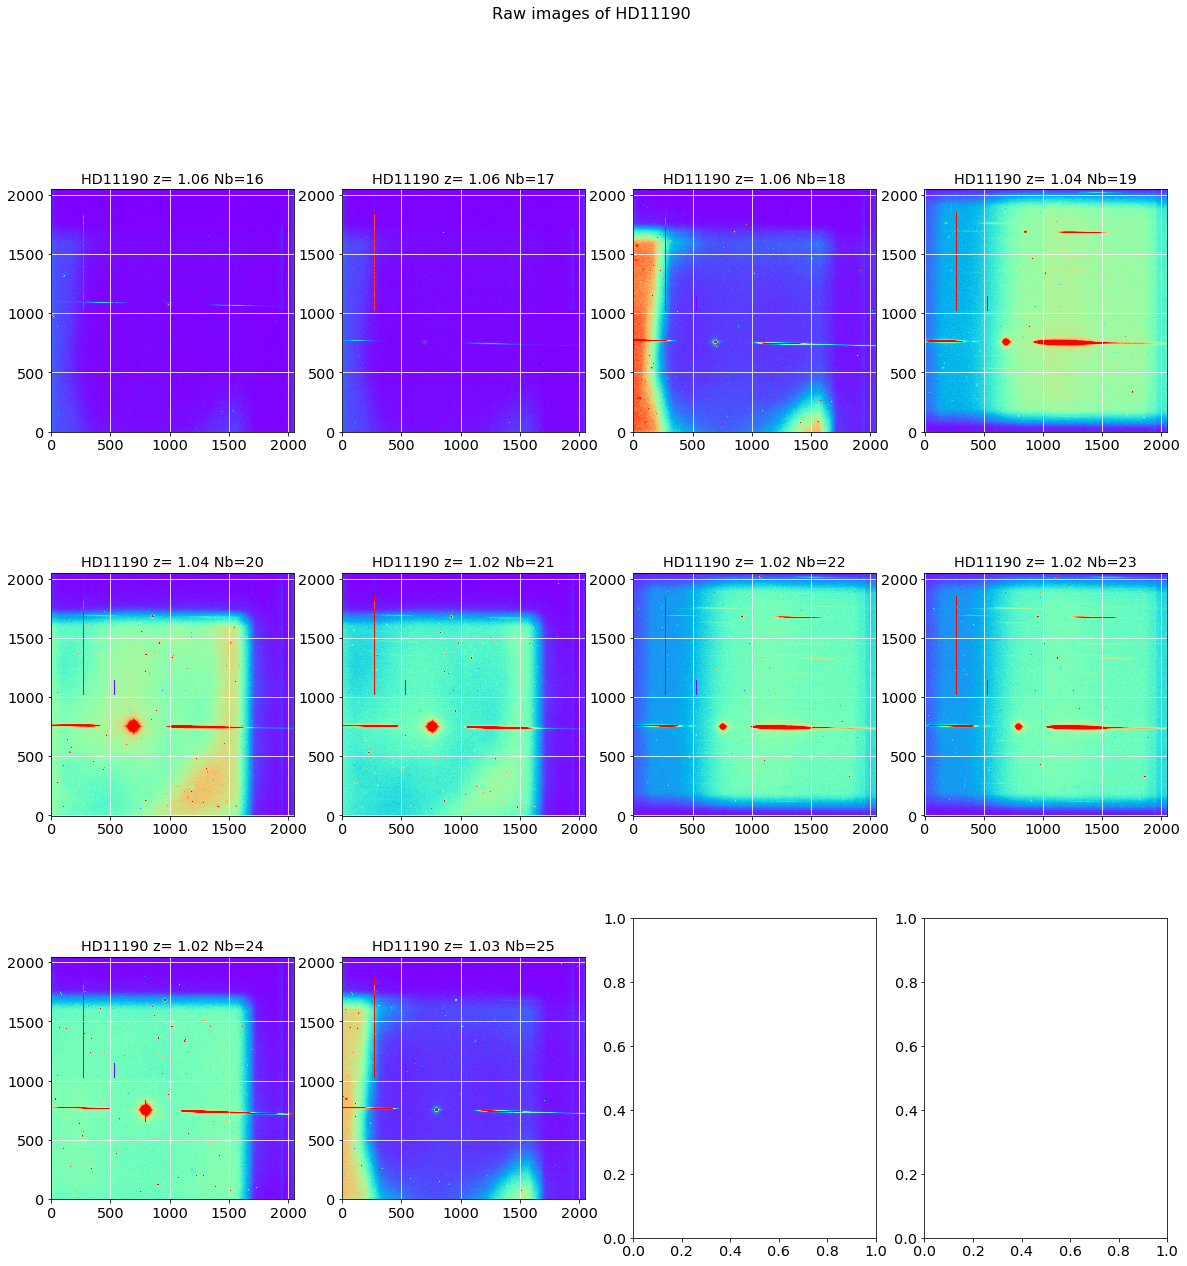

In [121]:
ShowRawImages()

### Find the star locations
----------------------------

In [122]:
%%cython
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind

def ComputeStatImages(all_images):
    """
    ComputeStatImages: 
    ==============
    """
    
    img_mean=[]
    img_median=[]
    img_std=[]
    img_sources=[]
    img_=[]
    index=0
    for image in all_images:
        mean, median, std = sigma_clipped_stats(image, sigma=10.0, iters=5)    
        print '----------------------------------------------------------------'
        print index,' mean, median, std = ',mean, median, std
        img_mean.append(mean)
        img_median.append(median)
        img_std.append(std)
        sources = daofind(image - median, fwhm=6.0, threshold=10000)
        print sources
        img_sources.append(sources)    
        index+=1
    return img_mean,img_median,img_std,img_sources

In [123]:
img_mean,img_median,img_std,img_sources=ComputeStatImages(all_images)

----------------------------------------------------------------
0  mean, median, std =  17.998778828 10.0 26.4220789591


        Use DAOStarFinder instead. [astropy.utils.decorators]


 id   xcentroid     ycentroid   ...   peak       flux           mag      
--- ------------- ------------- ... ------- ------------- ---------------
  1 13.9235775196 973.984828615 ... 10988.0 1.53173746574 -0.462960837933
  2 995.770796202 1079.13402867 ... 30132.0 3.83393951197  -1.45911314184
  3 107.220108134 1317.41127147 ...  9509.0 1.31300653948 -0.295667222789
----------------------------------------------------------------
1  mean, median, std =  19.9931638558 12.0 25.9837505594
 id   xcentroid     ycentroid   ...   peak       flux           mag      
--- ------------- ------------- ... ------- ------------- ---------------
  1 691.802742717 757.274616747 ... 21109.0 2.50004573622 -0.994869884488
----------------------------------------------------------------
2  mean, median, std =  151.45204904 80.0 217.760326151
 id   xcentroid     ycentroid   ...   peak       flux          mag      
--- ------------- ------------- ... ------- ------------- --------------
  1 690.927202501 7

In [126]:
sel=1

thesource=img_sources[sel]
img_size=all_images[sel].shape

print thesource

 id   xcentroid     ycentroid   ...   peak       flux           mag      
--- ------------- ------------- ... ------- ------------- ---------------
  1 691.802742717 757.274616747 ... 21109.0 2.50004573622 -0.994869884488


In [127]:
x_star=thesource["xcentroid"]
y_star=thesource["ycentroid"]
points_set=np.array(zip(x_star,y_star))

In [128]:
x_star[0]

691.80274271715359

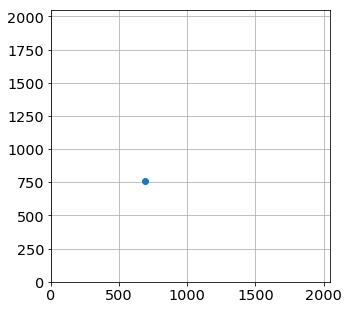

In [129]:
plt.figure(figsize=(5,5))
plt.plot(x_star,y_star,'o')
plt.xlim(0,img_size[1])
plt.ylim(0,img_size[0])
plt.grid(True)

### Search the main central star
----------------------------------

In [3]:
%cython
import numpy as np

"""
Set of routine to find the right position of the main central star
"""
def distance(v1,v2): 
    return sum([(x-y)**2 for (x,y) in zip(v1,v2)])**(0.5)

def GetDistanceSum(thepoint, points_set):
    """
    Return the distance sum of the point thepoit to the set of points points_set
    """
    dist_sum=0
    for otherpoint in points_set:
        dist= distance(thepoint,otherpoint)
        dist_sum+=dist
    return dist_sum

def GetAllDistanceSum(all_points):
    """
    Return the set of the distance sum to other point for all points
    """
    all_distances = []
    for thepoint in all_points:
        dist=GetDistanceSum(thepoint, all_points)
        all_distances.append(dist)
    all_distances=np.array(all_distances)
    return all_distances
        

def GetCentralPosition( x_star, y_star):
    """
    Find the position of the point which minimise the distance sum wrt other points
    """
    if x_star.size == 1:
        central_pos_index=0
        points_set=np.array(zip(x_star,y_star))
        return np.array([int(points_set[central_pos_index][1]),int(points_set[central_pos_index][0])])
    
    points_set=np.array(zip(x_star,y_star))
    distances_sum=GetAllDistanceSum(points_set)
    central_pos_index=np.where(distances_sum==distances_sum.min())[0][0]
    return np.array([int(points_set[central_pos_index][1]),int(points_set[central_pos_index][0])])

ERROR: Line magic function `%cython` not found.


In [131]:
def GetCentralPositionByMax(thesource):
    
    np.where(thesource["peak"]==thesource["peak"].max)


In [132]:
x_star.size

1

In [133]:
y_star.size

1

In [134]:
GetCentralPosition( x_star, y_star)

array([757, 691])

### Special way to find the right center of the main star

In [135]:
positions_central = []
index=0
for source in img_sources:
    print ' source ',index
    x_star=source["xcentroid"]
    y_star=source["ycentroid"]
    flux=source["flux"]
    position=GetCentralPosition(x_star,y_star)
    print position
    print flux
    positions_central.append(position)
    index+=1

 source  0
[1317  107]
     flux    
-------------
1.53173746574
3.83393951197
1.31300653948
 source  1
[757 691]
     flux    
-------------
2.50004573622
 source  2
[755 690]
     flux    
-------------
6.63928941335
 5.8981390468
 source  3
[751 690]
     flux    
-------------
8.07945323914
7.38086431095
 source  4
[1682  855]
     flux    
-------------
1.97375711766
 source  5
[767 760]
     flux    
-------------
5.83829817464
1.94341232092
 source  6
[1681  919]
     flux    
-------------
1.34763455477
 source  7
[1681  959]
     flux    
-------------
1.13083414358
 source  8
[1453 1018]
     flux    
-------------
1.11348461748
1.18155813045
 1.2694702584
1.31357116466
4.84182752048
 source  9
[754 796]
     flux    
-------------
5.54440508038
4.94972711828
1.28498293154


In [136]:
positions_central = []
index=0
for source in img_sources:
    print ' source ',index
    x_star=source["xcentroid"]
    y_star=source["ycentroid"]
#    position=GetCentralPosition(x_star,y_star)
    position=GetCentralPositionByMax(source)
    print position
    positions_central.append(position)
    index+=1

 source  0
None
 source  1
None
 source  2
None
 source  3
None
 source  4
None
 source  5
None
 source  6
None
 source  7
None
 source  8
None
 source  9
None


## If not working, put star selection by hand

In [161]:
positions_central = []
# 0
position= np.array([996,1079])
positions_central.append(position)
# 1
position= np.array([692,757])
positions_central.append(position)
# 2
position= np.array([691,761])
positions_central.append(position)
# 3
position= np.array([690,760])
positions_central.append(position)
# 4
position= np.array([855,760])
positions_central.append(position)
# 5
position= np.array([769,760])
positions_central.append(position)
# 6
position= np.array([919,760])
positions_central.append(position)
# 7
position= np.array([960,760])
positions_central.append(position)
# 8
position= np.array([990,760])
positions_central.append(position)
# 9
position= np.array([796,750])
positions_central.append(position)


In [156]:
positions_central 

[array([ 996, 1079]),
 array([692, 757]),
 array([691, 761]),
 array([690, 760]),
 array([855, 700]),
 array([769, 760]),
 array([919, 760]),
 array([960, 760]),
 array([990, 760]),
 array([796, 750])]

### Cut the image
------------------

In [139]:
DeltaY=200
DeltaX=600

In [169]:
#%%cython

import numpy as np
import matplotlib.pyplot as plt
from photutils import CircularAperture
import os

def ShowCenterImages(all_images,all_titles,object_name,positions_central,dir_top_images):
    """
    ShowCenterImages: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERLROW)+1
    
    #global dir_top_images
    
    croped_images = []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=(20,10))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        y0=int(positions_central[index][1])
        x0=int(positions_central[index][0])
       
        #image_cut=all_images[index][y0-200:y0+200,x0-200,y0+200]
        theimage=all_images[index]
        #image_cut=theimage[y0-DeltaY:y0+DeltaY,x0-DeltaX:x0+DeltaX]
        image_cut=np.copy(theimage[y0-DeltaY:y0+DeltaY,:])
        croped_images.append(image_cut)
        #aperture=CircularAperture([positions_central[index]], r=100.)
        im=axarr[iy,ix].imshow(image_cut,cmap='rainbow',vmin=0,vmax=1000,origin='lower',interpolation='None')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        #aperture.plot(color='red', lw=5.)
    title='Cut Images of {}'.format(object_name)
    plt.suptitle(title,size=16) 
    
    figfilename=os.path.join(dir_top_images,'cut_images.pdf')
    plt.savefig(figfilename)   
    
    
    return croped_images

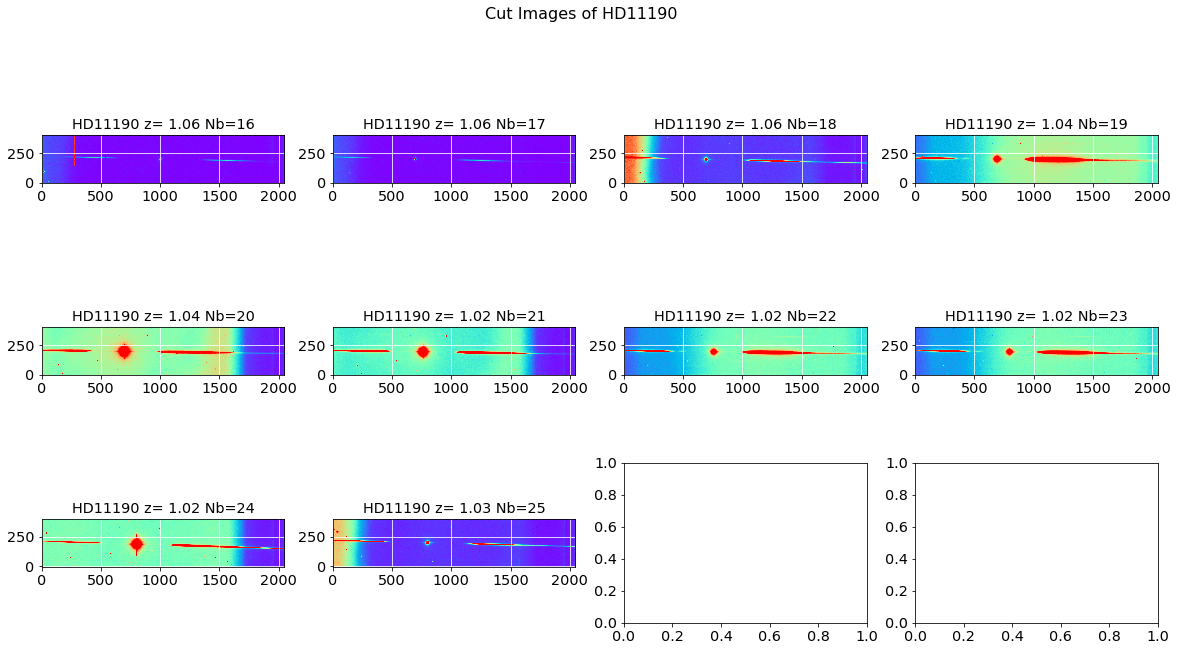

In [170]:
images_cut=ShowCenterImages(all_images,all_titles,object_name,positions_central,dir_top_images)

#### Example of cut image
-------------------------

In [171]:
index=0
data=np.copy(images_cut[index])
w=20
ws=80
data[:,DeltaX-ws:DeltaX+ws]=0

In [172]:
yprofile=np.sum(data,axis=1)
xprofile=np.sum(data,axis=0)

In [173]:
y_center=np.where(yprofile==yprofile.max())[0][0]
print y_center

200


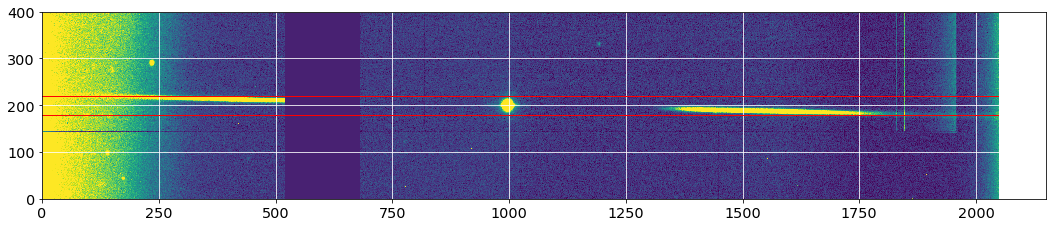

In [175]:
plt.figure(figsize=(18,18))
y0=int(positions_central[index][0])
x0=int(positions_central[index][1])
plt.imshow(data,vmin=-10,vmax=100,origin='lower',interpolation='None')
plt.plot([0,data.shape[1]],[y_center-w,y_center-w],'r-',lw=1)
plt.plot([0,data.shape[1]],[y_center+w,y_center+w],'r-',lw=1)
plt.grid(color='white', ls='solid')
plt.show()
figfilename=os.path.join(dir_top_images,'cutimages_sample.pdf')
plt.savefig(figfilename)   

### prepare outputfilename

In [192]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    
    short_infilename=file.split("/")[3]
    print short_infilename
    short_partfilename=re.findall('^trim_(.*)',short_infilename)
    short_outfilename='cutimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

trim_20170528_016.fits
trim_20170528_017.fits
trim_20170528_018.fits
trim_20170528_019.fits
trim_20170528_020.fits
trim_20170528_021.fits
trim_20170528_022.fits
trim_20170528_023.fits
trim_20170528_024.fits
trim_20170528_025.fits


### Save outputfilename

In [193]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)

In [194]:
!ls -l cut_fitsimages/*

-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 29 15:03 cut_fitsimages/cutimg_20170528_016.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 29 15:03 cut_fitsimages/cutimg_20170528_017.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 29 15:03 cut_fitsimages/cutimg_20170528_018.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 29 15:03 cut_fitsimages/cutimg_20170528_019.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 29 15:03 cut_fitsimages/cutimg_20170528_020.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 29 15:03 cut_fitsimages/cutimg_20170528_021.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 29 15:03 cut_fitsimages/cutimg_20170528_022.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 29 15:03 cut_fitsimages/cutimg_20170528_023.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 29 15:03 cut_fitsimages/cutimg_20170528_024.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6